In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# импортируем библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42

In [3]:
# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы:
!pip freeze > requirements.txt

In [4]:
# Подгрузим наши данные
df_train = pd.read_csv('hotels_train.csv') # датасет для обучения
df_test = pd.read_csv('hotels_test.csv') # датасет для предсказания
sample_submission = pd.read_csv('submission.csv') # самбмишн

# <center>Знакомство с данными</center>

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

In [6]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 16 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               128935 non-null  object 
 1   additional_number_of_scoring                128935 non-null  int64  
 2   review_date                                 128935 non-null  object 
 3   average_score                               128935 non-null  float64
 4   hotel_name                                  128935 non-null  object 
 5   reviewer_nationality                        128935 non-null  object 
 6   negative_review                             128935 non-null  object 
 7   review_total_negative_word_counts           128935 non-null  int64  
 8   total_number_of_reviews                     128935 non-null  int64  
 9   positive_review                             128935 non-null  object 
 

In [8]:
df_test.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
0,Via Senigallia 6 20161 Milan Italy,904,7/21/2017,8.1,Hotel Da Vinci,United Kingdom,Would have appreciated a shop in the hotel th...,52,16670,Hotel was great clean friendly staff free bre...,62,1,"[' Leisure trip ', ' Couple ', ' Double Room '...",13 days,45.533137,9.171102
1,Arlandaweg 10 Westpoort 1043 EW Amsterdam Neth...,612,12/12/2016,8.6,Urban Lodge Hotel,Belgium,No tissue paper box was present at the room,10,5018,No Positive,0,7,"[' Leisure trip ', ' Group ', ' Triple Room ',...",234 day,52.385649,4.834443


In [9]:
sample_submission.head(2)

,reviewer_score,id
0,1,488440
1,10,274649


In [10]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype
---  ------          --------------   -----
 0   reviewer_score  128935 non-null  int64
 1   id              128935 non-null  int64
dtypes: int64(2)
memory usage: 2.0 MB


# <center>Проектирование и преобразование признаков</center>

In [11]:
# Для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['reviewer_score'] = 0 # в тесте у нас нет значения reviewer_score, мы его должны предсказать, поэтому пока просто заполняем нулями

hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

C:\Users\Leon\AppData\Local\Temp\ipykernel_10448\1825887292.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hotels = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем


In [12]:
# В признаках 'lat' и 'lng' имеются пропуски. Заполним их нулями.
hotels[['lat', 'lng']] = hotels[['lat', 'lng']].fillna(value=0)

In [13]:
# Убеждаемся, что пропусков не осталось.
hotels.isnull().sum()

hotel_address                                 0
additional_number_of_scoring                  0
review_date                                   0
average_score                                 0
hotel_name                                    0
reviewer_nationality                          0
negative_review                               0
review_total_negative_word_counts             0
total_number_of_reviews                       0
positive_review                               0
review_total_positive_word_counts             0
total_number_of_reviews_reviewer_has_given    0
tags                                          0
days_since_review                             0
lat                                           0
lng                                           0
sample                                        0
reviewer_score                                0
dtype: int64

In [14]:
# Создаем признак страны расположения, так как в разных странах свой уровень обслуживания клиентов и этот показатель может стать важным фактором.
# Определение страны по указанному адресу:
def country(address):
    """
    Извлекает из признака с адресом название страны расположения.    
    Args:
        address (str): указанный адресс отелей.
    Returns:
        str: страна расположения отеля.
    """
    address_list = address.split(' ')
    x1 = address_list[-2]
    x2 = address_list[-1]
    country = str(x1+' '+x2)
    return country

# Создаем признак страны расположения.
hotels['country'] = hotels['hotel_address'].apply(country)

In [15]:
# Создаем признак с названием сезона, так как поток клиентов и туристов зачастую сильно зависят от сезона.
# Определение сезона в зависимости от указанного времени:
winter_list = [12, 1, 2]
spring_list = [3, 4, 5]
summer_list = [6, 7, 8]
def season(date):
    """
    Преобразовывает дату оставленного отзыва в наименование сезона.
    Args:
        date (pd.to_datetime): аргумент в виде pandas.datetime.
    Returns:
        str: сезон.
    """
    if date in winter_list:
        return 'winter'
    elif date in spring_list:
        return 'spring'
    elif date in summer_list:
        return 'summer'
    else:
        return 'autumn'

# Преобразуем строковое значение даты в формат pandas.datetime.
hotels['review_date'] = pd.to_datetime(hotels['review_date'], format='%m/%d/%Y')

# Создаем признак с названием сезона.
hotels['season'] = hotels['review_date'].dt.month.apply(season)

# После определения сезона удаляем дату за ненадобностью.
hotels = hotels.drop(['review_date'], axis=1)

In [16]:
# Преобразуем строковый признак 'days_since_review' в числовой.
hotels['days_since_review'] = hotels['days_since_review'].apply(lambda x: int((x.split())[0]))

# <center>Очистка данных</center>

In [17]:
# Удаляем негативные отзывы, так как очень много уникальных значений.
# Можно воспользоваться количеством негативных слов 'review_total_negative_word_counts':
hotels = hotels.drop(['negative_review'], axis=1)

# Удаляем позитивные отзывы, так как очень много уникальных значений.
# Можно воспользоваться количеством позитивных слов 'review_total_positive_word_counts':
hotels = hotels.drop(['positive_review'], axis=1)

# Удаляем теги, так как число уникальных тегов очень велико и они не поддаются обработке:
hotels = hotels.drop(['tags'], axis=1)

# Удаляем адресс отеля, так как из него уже извлечен признак с названием страны:
hotels = hotels.drop(['hotel_address'], axis=1)

In [18]:
# Статистические данные.
hotels.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,sample,reviewer_score
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,354.441932,49.129144,2.805910,0.749999,6.297672
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,208.928124,5.227925,4.570389,0.433014,3.902295
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,0.000000,-0.369758,0.000000,0.000000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,175.000000,48.212857,-0.143372,0.250000,0.625000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,353.000000,51.499981,0.000000,1.000000,7.900000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,527.000000,51.516288,4.831098,1.000000,9.600000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,730.000000,52.400181,16.429233,1.000000,10.000000


Далее визуализируем следующие признаки на наличие выбросов, так как в них имеется большой разброс по значениям:
    
- additional_number_of_scoring
- review_total_negative_word_counts
- review_total_positive_word_counts
- total_number_of_reviews_reviewer_has_given

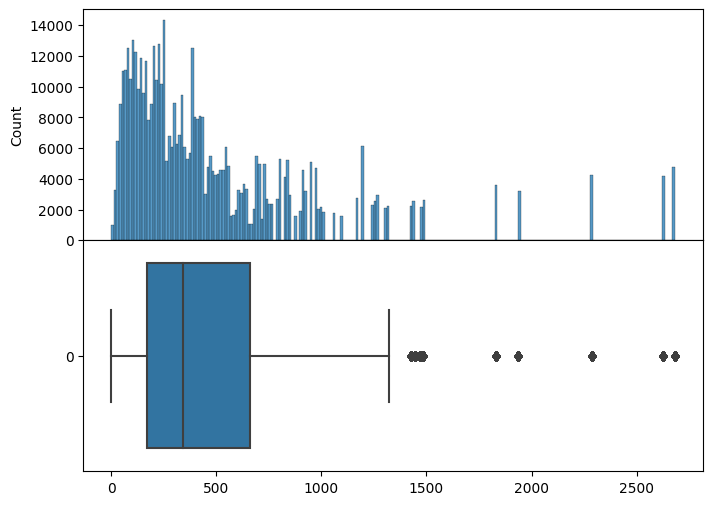

In [19]:
# Визуализируем признак 'additional_number_of_scoring'.
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
plt.subplots_adjust(hspace=.0)
histplot = sns.histplot(data=hotels['additional_number_of_scoring'], ax=axes[0])
boxplot = sns.boxplot(data=hotels['additional_number_of_scoring'], orient='h', ax=axes[1])

In [20]:
# В признаке 'additional_number_of_scoring' заметны некоторые выбросы свыше 1400. Удалим их.
# Создаем индексы, где признак превышает значение 1400.
outliers_ad_num_scor = hotels[hotels['additional_number_of_scoring'] > 1400]
# Удаляем строки по полученным индексам.
hotels = hotels.drop(outliers_ad_num_scor.index, axis=0)

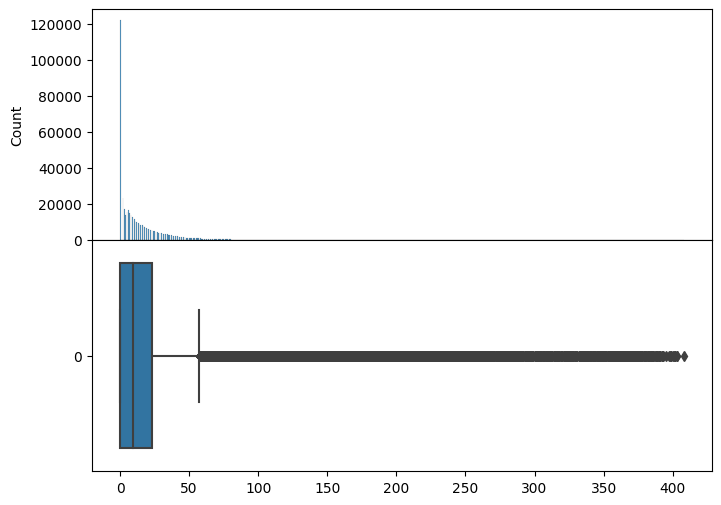

In [21]:
# Визуализируем признак 'review_total_negative_word_counts'. Выбросов не обнаружено.
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
plt.subplots_adjust(hspace=.0)
histplot = sns.histplot(data=hotels['review_total_negative_word_counts'], ax=axes[0])
boxplot = sns.boxplot(data=hotels['review_total_negative_word_counts'], orient='h', ax=axes[1])

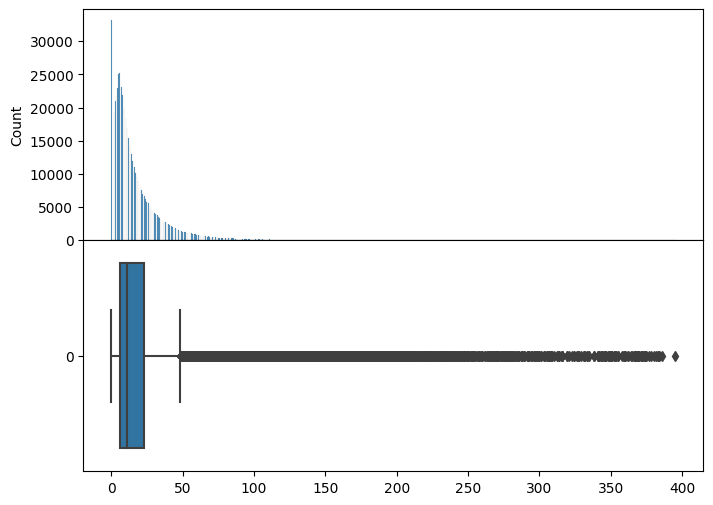

In [22]:
# Визуализируем признак 'review_total_positive_word_counts'. Выбросов не обнаружено.
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
plt.subplots_adjust(hspace=.0)
histplot = sns.histplot(data=hotels['review_total_positive_word_counts'], ax=axes[0])
boxplot = sns.boxplot(data=hotels['review_total_positive_word_counts'], orient='h', ax=axes[1])

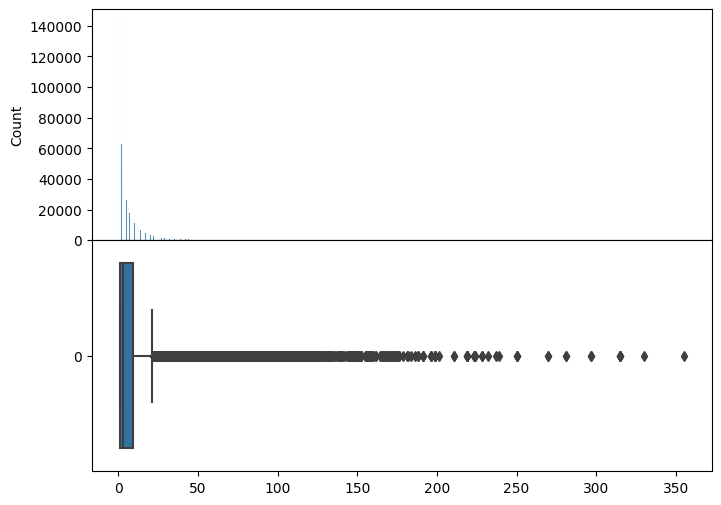

In [23]:
# Визуализируем признак 'total_number_of_reviews_reviewer_has_given'.
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
plt.subplots_adjust(hspace=.0)
histplot = sns.histplot(data=hotels['total_number_of_reviews_reviewer_has_given'], ax=axes[0])
boxplot = sns.boxplot(data=hotels['total_number_of_reviews_reviewer_has_given'], orient='h', ax=axes[1])

In [24]:
# Избавляемся от выбросов в признаке 'total_number_of_reviews_reviewer_has_given', значения которых превышает 200.
outliers_tot_num_rev_giv = hotels[hotels['total_number_of_reviews_reviewer_has_given'] > 200]
hotels = hotels.drop(outliers_tot_num_rev_giv.index, axis=0)

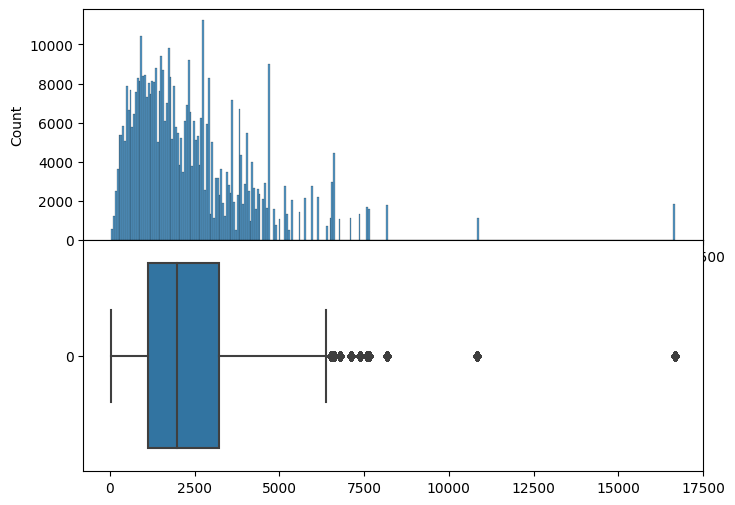

In [25]:
# Визуализируем признак 'total_number_of_reviews'.
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))
plt.subplots_adjust(hspace=.0)
histplot = sns.histplot(data=hotels['total_number_of_reviews'], ax=axes[0])
boxplot = sns.boxplot(data=hotels['total_number_of_reviews'], orient='h', ax=axes[1])

In [26]:
# Избавляемся от выбросов в признаке 'total_number_of_reviews' выше 10000.
outliers_reviews = hotels[hotels['total_number_of_reviews'] > 10000]
hotels = hotels.drop(outliers_reviews.index, axis=0)

In [27]:
# Сбрасываем индексы после очистки.
hotels.reset_index(drop=True, inplace=True)

# <center>Определение корреляций и отбор признаков</center>

C:\Users\Leon\AppData\Local\Temp\ipykernel_10448\3545337551.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  heatmap = sns.heatmap(hotels.corr(method = 'spearman'), annot = True)


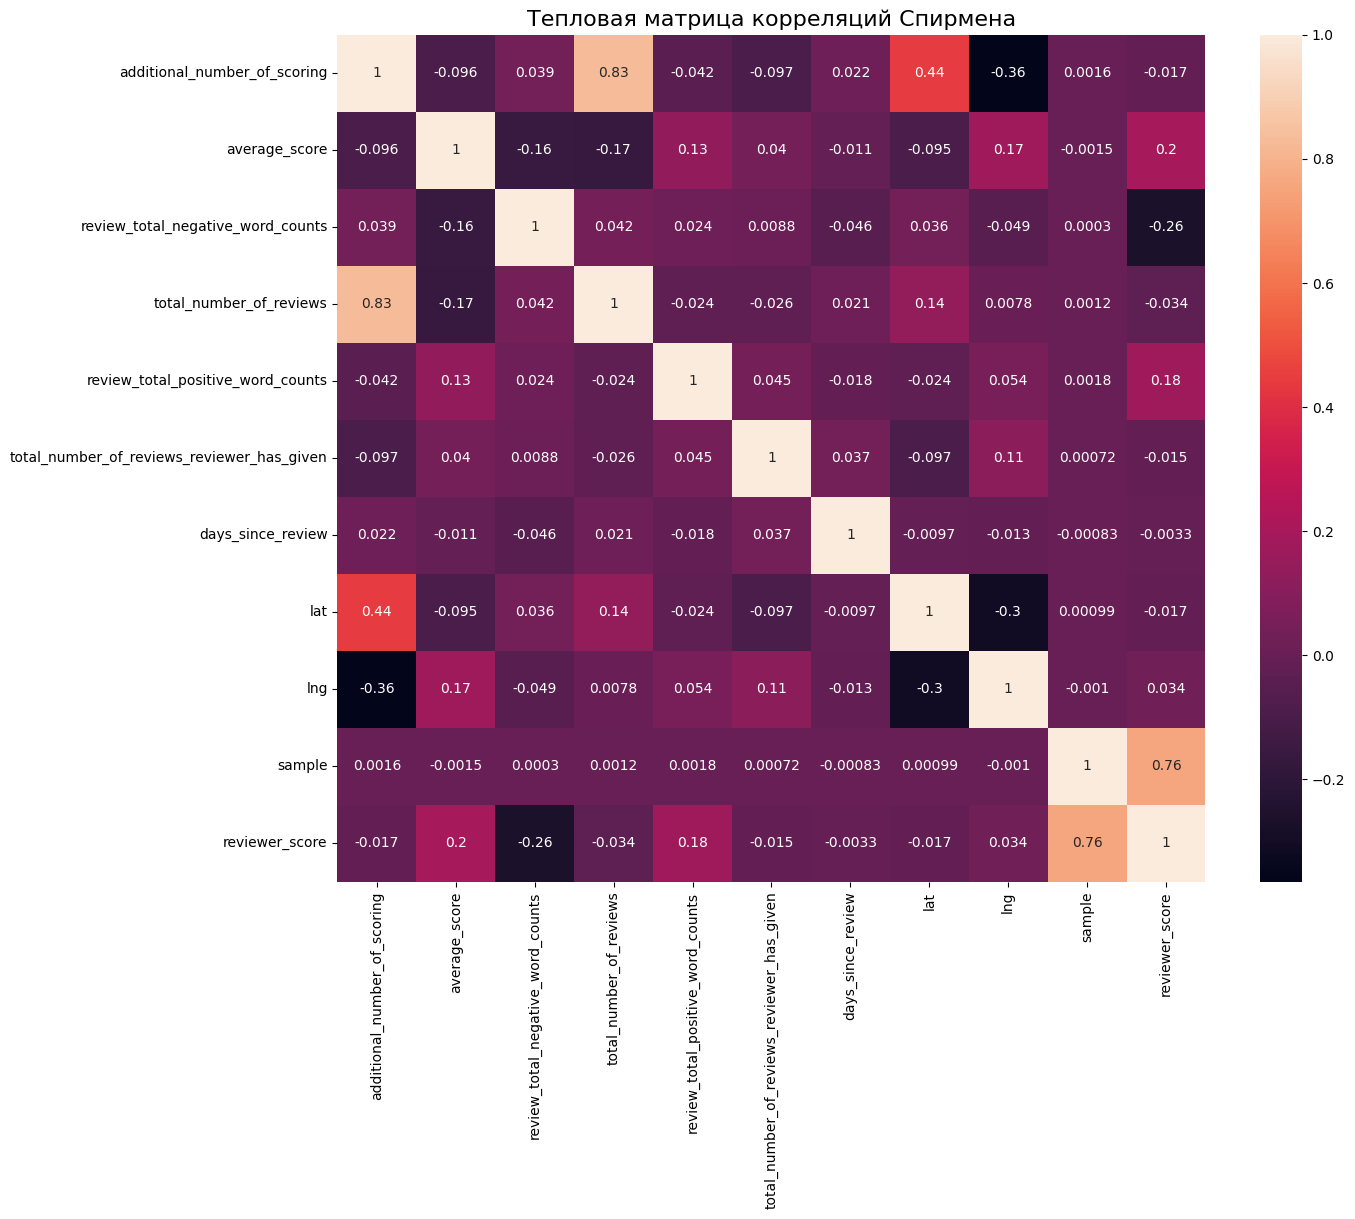

In [28]:
# Матрица корреляций по Спирмену.
fig = plt.figure(figsize=(14, 11))
heatmap = sns.heatmap(hotels.corr(method = 'spearman'), annot = True)
heatmap.set_title('Тепловая матрица корреляций Спирмена', fontsize=16)
plt.show()

In [29]:
# По матрице корреляции видно, что есть сильная связь между признаками 'additional_number_of_scoring' и 'total_number_of_reviews',
# Удалим признак 'total_number_of_reviews'. Признак sample не трогаем, так как он будет использован в дальнейшем:
hotels = hotels.drop(['total_number_of_reviews'], axis=1)

# <center>Кодирование признаков</center>

In [30]:
# Количество уникальных значений.
hotels.nunique(dropna=False)

additional_number_of_scoring                   470
average_score                                   34
hotel_name                                    1481
reviewer_nationality                           226
review_total_negative_word_counts              402
review_total_positive_word_counts              363
total_number_of_reviews_reviewer_has_given     180
days_since_review                              731
lat                                           1462
lng                                           1462
sample                                           2
reviewer_score                                  38
country                                          6
season                                           4
dtype: int64

In [31]:
import category_encoders as ce # импортируем библиотеку для работы с кодировщиками

# Для признака reviewer_nationality используем бинарное кодирование Binary Encoding:
bin_encoder = ce.BinaryEncoder(cols=['reviewer_nationality'])
type_bin = bin_encoder.fit_transform(hotels['reviewer_nationality'])
hotels = pd.concat([hotels, type_bin], axis=1)

# Признак 'country' кодируем номинальным методом OneHot Encoding:
hotels = pd.get_dummies(hotels, columns=['country'])

# Признак 'season' кодируем номинальным методом OneHot Encoding.
hotels = pd.get_dummies(hotels, columns=['season'])

In [32]:
# Удаляем признаки с типом object, так как они не подходят для машинного обучения.
object_columns = [s for s in hotels.columns if hotels[s].dtypes == 'object']
hotels.drop(object_columns, axis=1, inplace=True)

# Выводим получившийся результат.
hotels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 483132 entries, 0 to 483131
Data columns (total 28 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   additional_number_of_scoring                483132 non-null  int64  
 1   average_score                               483132 non-null  float64
 2   review_total_negative_word_counts           483132 non-null  int64  
 3   review_total_positive_word_counts           483132 non-null  int64  
 4   total_number_of_reviews_reviewer_has_given  483132 non-null  int64  
 5   days_since_review                           483132 non-null  int64  
 6   lat                                         483132 non-null  float64
 7   lng                                         483132 non-null  float64
 8   sample                                      483132 non-null  int64  
 9   reviewer_score                              483132 non-null  float64
 

# <center>Обучение модели</center>

In [33]:
# Теперь выделим тестовую часть
train_data = hotels.query('sample == 1').drop(['sample'], axis=1)
test_data = hotels.query('sample == 0').drop(['sample'], axis=1)

y = train_data.reviewer_score.values # наш таргет
X = train_data.drop(['reviewer_score'], axis=1)

In [34]:
# Воспользуемся специальной функцией train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [35]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((120772, 27), (362360, 27), (362360, 26), (289888, 26), (72472, 26))

In [36]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [37]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [38]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   35.3s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  1.5min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.3s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    0.9s finished


In [39]:
# При помощи функции сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика Mean Absolute Percentage Error (MAPE) показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print('MAPE:', mean_absolute_percentage_error(y_test, y_pred))

MAPE: 13.380704461352652


<AxesSubplot: >

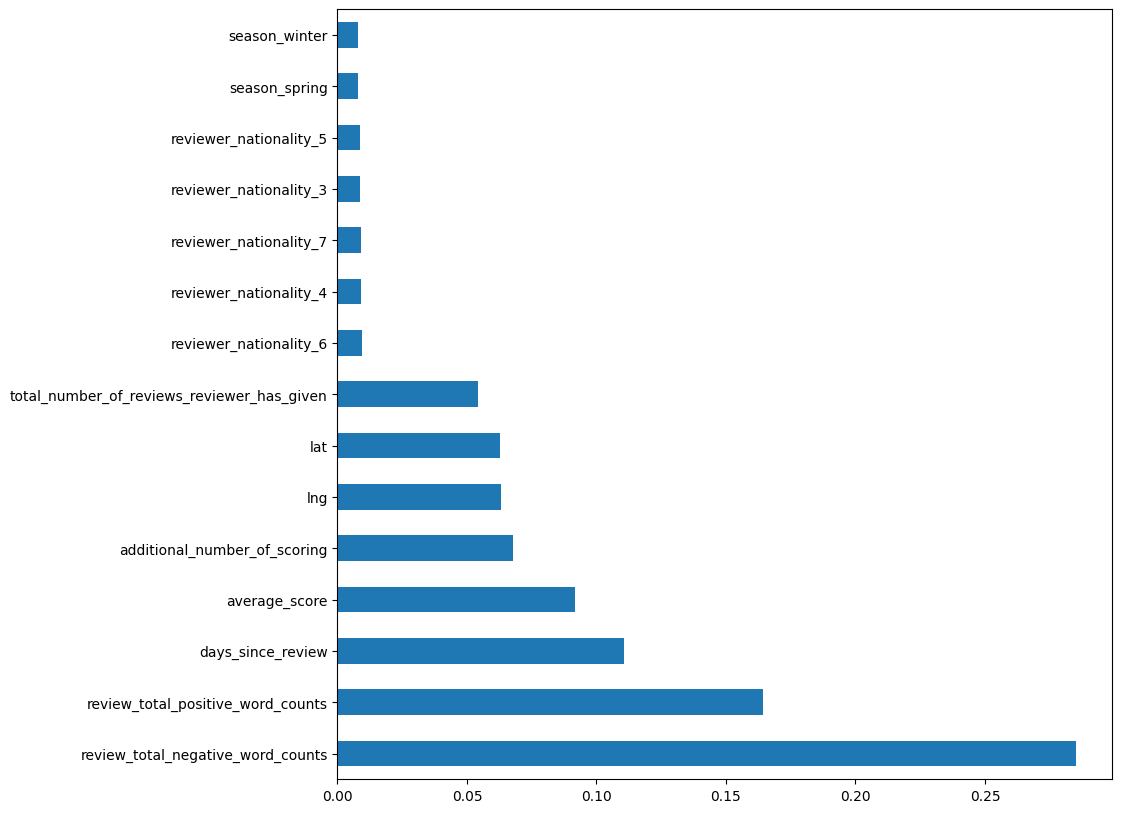

In [40]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

In [41]:
test_data.sample(10)

,additional_number_of_scoring,average_score,review_total_negative_word_counts,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,days_since_review,lat,lng,reviewer_score,reviewer_nationality_0,...,country_Amsterdam Netherlands,country_Barcelona Spain,country_Milan Italy,country_Paris France,country_United Kingdom,country_Vienna Austria,season_autumn,season_spring,season_summer,season_winter
29361,160,8.2,0,10,2,665,48.868643,2.298405,0.0,0,...,0,0,0,1,0,0,1,0,0,0
78973,417,6.7,11,30,2,256,51.512450,-0.179522,0.0,0,...,0,0,0,0,1,0,1,0,0,0
32045,315,9.4,38,12,1,701,51.511192,-0.119401,0.0,0,...,0,0,0,0,1,0,1,0,0,0
70539,64,9.2,0,57,4,589,45.463044,9.183607,0.0,0,...,0,0,1,0,0,0,0,0,0,1
68434,1243,8.1,21,14,23,396,51.513556,-0.180002,0.0,0,...,0,0,0,0,1,0,0,0,1,0
63051,451,8.5,15,12,1,532,52.373527,4.893304,0.0,0,...,1,0,0,0,0,0,0,0,0,1
11544,362,8.1,15,16,2,197,51.529257,-0.168358,0.0,0,...,0,0,0,0,1,0,0,0,0,1
103964,493,9.0,0,6,6,393,45.460860,9.189022,0.0,0,...,0,0,1,0,0,0,0,0,1,0
111997,589,7.0,13,4,1,669,52.366373,4.893051,0.0,0,...,1,0,0,0,0,0,1,0,0,0
35323,233,8.7,36,0,1,65,51.505483,-0.095120,0.0,0,...,0,0,0,0,1,0,0,1,0,0


In [42]:
test_data = test_data.drop(['reviewer_score'], axis=1)

In [43]:
sample_submission

,reviewer_score,id
0,1,488440
1,10,274649
2,3,374688
3,10,404352
4,9,451596
...,...,...
128930,7,495812
128931,1,315577
128932,3,511968
128933,6,303386


In [44]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.5s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    1.6s finished


In [45]:
predict_submission

array([6.936, 8.204, 9.545, ..., 7.902, 9.509, 7.52 ])

In [46]:
list(sample_submission)

['reviewer_score', 'id']

In [47]:
# sample_submission['reviewer_score'] = predict_submission
# sample_submission.to_csv('submission.csv', index=False)
# sample_submission.head(10)